# X3D (eXpanded 3D) Implementation - Design Alternative 1

`Warning:` Do not run all the code, read the notes first before running them as they may reduce your device's memory when not careful, leading to a kernel crash or Out-Of-Memory (OOM) Error, sige ka magla-lag yang pc mo

`Remarks`: Yeyyyyy panalo raw toh sa Sensiitivity Analysis

**Local System Specifications used to train the model:** <br>
| Component  | Device   |
| :------------- | :--------------- | 
| CPU   | AMD Ryzen 5 5600x     | 
| GPU   | Nvidia GeForce RTX 3070  8GB   | 
| RAM   | 32 GB     | 


## Create the dataset

#### Import Libraries and Configure Device

In [ ]:
## Uncomment if you are running on colab, you'll need this :)

#!pip install imageio opencv-python tqdm seaborn scikit-learn pandas matplotlib mediapipe moviepy PyQt5

#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 # For Windows
#!pip3 install torch torchvision torchaudio # For Linux, mag linux na lang

#!pip install pytorchvideo
#!pip install lightning

#!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
#!unrar x UCF101.rar

In [1]:
from tqdm import tqdm
import random
import pathlib
import os

import shutil
import cv2
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.v2 import *

In [2]:
torch.cuda.is_available(), torch.cuda.get_device_name() # Check if GPU is available, baka mamaya sa CPU tayo nagte-training

(True, 'NVIDIA GeForce RTX 3070')

#### Visualize the data first

In [3]:
def visulize_data(fil_dir): 
    """ 
    Let's you visualize the video

    Args:
        fil_dir: Directory of files

    Returns:
        Plot of videos along with the labels

    """

    plt.figure(figsize=(20, 20))
    all_class_names = os.listdir(path=fil_dir)
    random_range = random.sample(range(len(all_class_names)), len(all_class_names))

    for counter, rand_idx in enumerate(random_range, 1):
        selected_class_name = all_class_names[rand_idx]
        video_files_names_list = os.listdir(f'{fil_dir}/{selected_class_name}')
        selected_video_file_name = random.choice(video_files_names_list)

        # Read the video file, get the frame, isang frame lang
        video_reader = cv2.VideoCapture(f'{fil_dir}/{selected_class_name}/{selected_video_file_name}')
        _, frame = video_reader.read()
        video_reader.release()

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)

        plt.subplot(5, 4, counter)
        plt.imshow(rgb_frame)
        plt.axis('off') #✅

#### Loading of dataset

`Note`: Implementation is taken/Inspired from [Video classification with a 3D convolutional neural network](https://www.tensorflow.org/tutorials/video/video_classification) 

In [5]:
## Define the dimensions of frames in the set of frames created (Default params muna)
SIZE = 128
SEQUENCE_LENGTH = 20 # Number of frames in a sequence
BATCH = 12 # Lower is slower, more accurate but may overfit, vice-versa. (define the number based on what your system can handle, wag pilitin maawa ka)
LABELS = sorted(['BarbellCurl', 'Deadlift', 'Squat', 'LateralRaises', 'OverheadPress']) #✅

- `Note`: Classes can be changed later on once model is okay (Edit: Ok na yan, wag na dagdagan)

In [6]:
## Balance the dataset muna
def balance_dataset_before_split(dataset_dir):
    """
    Balance the number of files in each folder before splitting by randomly deleting excess files
    to match the lowest count. For balancing purposes
    """
    print("\nBalancing dataset...")
    dataset_dir = pathlib.Path(dataset_dir)

    # Get all class subdirectories
    class_dirs = [d for d in dataset_dir.iterdir() if d.is_dir()]
    
    # Count the number of files in each class directory
    file_counts = {class_dir: len(list(class_dir.iterdir())) for class_dir in class_dirs}
    
    # Find the lowest file count
    lowest_count = min(file_counts.values())
    
    print(f"Lowest file count across classes: {lowest_count}\n\n")

    # Balance each class directory
    for class_dir, count in file_counts.items():
        if count > lowest_count:
            excess_files = random.sample(list(class_dir.iterdir()), count - lowest_count)
            for file in tqdm(excess_files, desc=f"Balancing {class_dir.name}", unit="file"):
                file.unlink()

def split_dataset(dataset_dir, 
                  splits={"train": 0.7, "val": 0.15, "test": 0.15}, 
                  seed=42, 
                  selected_classes=None):
    """
    Split the video dataset into train, validation, and test sets and save to subdirectories.
    Ensures no data duplication across splits.
    """
    random.seed(seed)

    # Convert dataset directory to Path object
    dataset_dir = pathlib.Path(dataset_dir)
    splits_dirs = ["train", "val", "test"]

    # Check if splits are existing
    if sum([1 for _ in splits_dirs if _ in os.listdir(dataset_dir)]) == len(splits_dirs):
        print("Existing Splits found:", os.listdir(dataset_dir))
        count = 0

        for split in os.listdir(dataset_dir):
            for classes in os.listdir(os.path.join(dataset_dir, split)):
                for file in os.listdir(os.path.join(dataset_dir, split, classes)):
                    count+=1
        print("Total Number of Files:", count)
    else:
        balance_dataset_before_split(dataset_dir)

        # Iterate over each class folder in the dataset
        class_dirs = [f for f in dataset_dir.iterdir() if f.is_dir()]

        if selected_classes:
            class_dirs = [f for f in class_dirs if f.name in selected_classes]
        
        for class_dir in tqdm(class_dirs, desc="Processing classes", unit="class"):
            print(f"\nProcessing class: {class_dir.name}")
            
            # Get a list of video files in the class directory
            video_files = [f for f in class_dir.iterdir() if f.is_file()]
            
            random.shuffle(video_files)
            
            num_videos = len(video_files)
            train_end = int(splits["train"] * num_videos)
            val_end = train_end + int(splits["val"] * num_videos)
            
            # Split the video files into train, val, and test 
            train_files = video_files[:train_end]
            val_files = video_files[train_end:val_end]
            test_files = video_files[val_end:]
            
            # Move files to directories (train, val, test)
            for split, files in zip(splits_dirs, [train_files, val_files, test_files]):
                split_dir = dataset_dir / split / class_dir.name
                split_dir.mkdir(parents=True, exist_ok=True)  # Create the class folder in the split directory
                
                for file in tqdm(files, desc=f"Moving files to {split}/{class_dir.name}", unit="file"):
                    shutil.move(str(file), str(split_dir / file.name))
        
        print("\nDataset split complete!")

In [7]:
## File path
file_path = './PD_Dataset/' 

In [8]:
## Split the dataset
split_dataset(file_path, splits={"train": 0.7, "val": 0.20, "test": 0.10}, seed=43, selected_classes=LABELS) # If lumabas yung mga labels ibig sabihin nun tiamand lang ako tanggalin

Existing Splits found: ['BarbellCurl', 'Deadlift', 'LateralRaises', 'OverheadPress', 'Squat', 'test', 'train', 'val']
Total Number of Files: 610


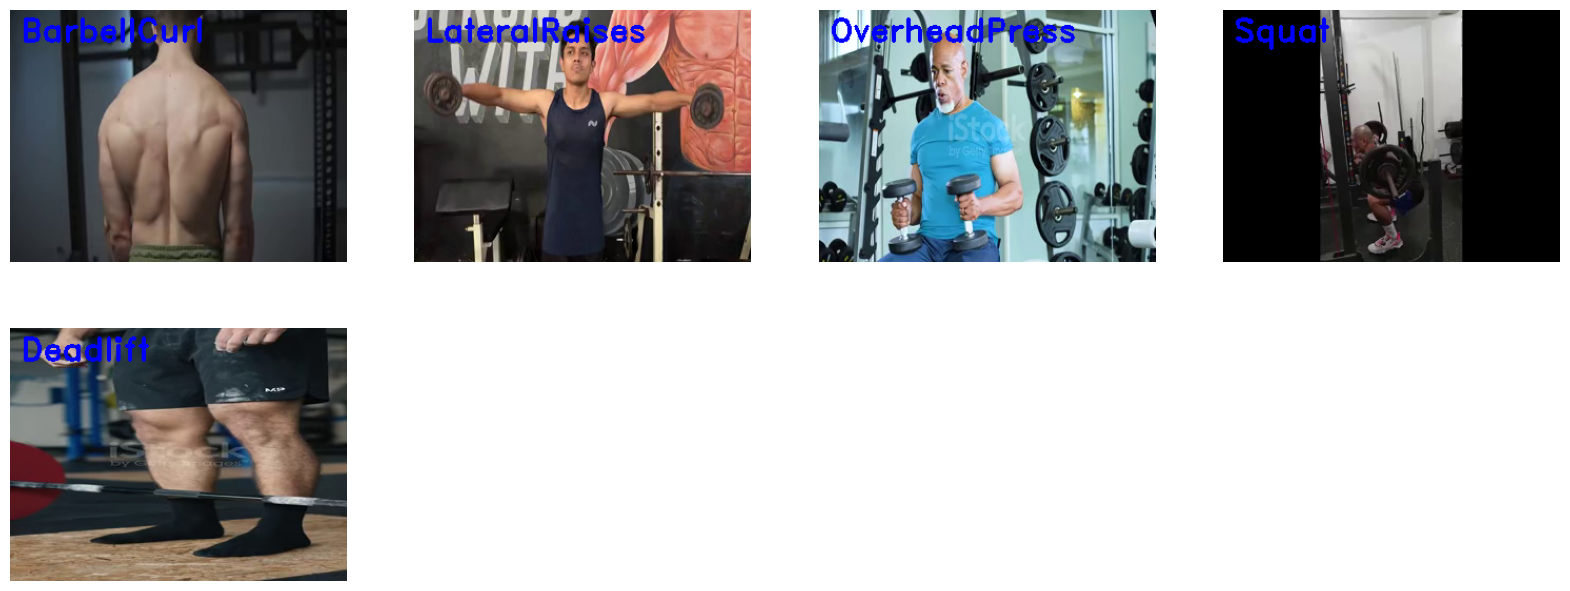

In [9]:
visulize_data(file_path + 'train/')

In [10]:
## If windows, use this
#temp = pathlib.PosixPath # Temp variable for PosixPath in case na mabaliw ka sa error ng pathlib
pathlib.PosixPath = pathlib.WindowsPath # Redirection of PosixPath to WindowsPath

In [11]:
## Creates a path to the dataset
dataset_paths = {'train':pathlib.PosixPath(f'{file_path}train'),
                    'val':pathlib.PosixPath(f'{file_path}val'),
                    'test':pathlib.PosixPath(f'{file_path}test')}

#### Pre-Processing of Video Datasets

In [12]:
class VideoDataset(Dataset):
    def __init__(self, root_dir, frame_height=224, frame_width=224, sequence_length=30, transform=None):
        """
        Args:
            root_dir (str): Root directory of the dataset, containing subdirectories for each label.
            transform (callable, optional): Optional transform to be applied on a video sample.
            frame_height (int): Height of the frames after resizing.
            frame_width (int): Width of the frames after resizing.
            sequence_length (int): Number of frames to use from each video.
        """
        self.root_dir = root_dir
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.sequence_length = sequence_length
        self.transform = transform  # Store the transform parameter, it's a surpiese tool that can help us later ;)

        self.video_paths = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # Collect video paths and corresponding labels
        self._prepare_data()

        print(f"Total videos found: {len(self.video_paths)}")
        print(f"Class to index mapping: {self.class_to_idx}")
        print(f"Video paths (first 5): {self.video_paths[:5]}")

    def _prepare_data(self):
        """
        Traverse the root directory and collect video paths and labels.
        """
        for label_idx, label_folder in enumerate(os.listdir(self.root_dir)):
            label_path = os.path.join(self.root_dir, label_folder)
            if os.path.isdir(label_path):
                # Create a mapping from label name to label index
                self.class_to_idx[label_folder] = label_idx
                self.idx_to_class[label_idx] = label_folder

                # Collect video paths for each label
                for video_name in os.listdir(label_path):
                    video_path = os.path.join(label_path, video_name)
                    if os.path.isfile(video_path) and video_path.endswith('.avi'):
                        self.video_paths.append(video_path)
                        self.labels.append(label_idx)

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        frames = self.load_video(video_path)

        return torch.tensor(frames), torch.tensor(label)

    def load_video(self, video_path):
        """
        Load the video, extract frames, resize them to the target size, and apply dynamic frame skipping.
        """
        cap = cv2.VideoCapture(video_path)

        # Get the total number of frames in the video
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Calculate the frame skip dynamically
        frame_skip = max((total_frames // self.sequence_length), 1)

        frames = []
        frame_count = 0

        while len(frames) < self.sequence_length and cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Skip frames based on the dynamic frame_skip parameter
            if frame_count % frame_skip == 0:
                frame = cv2.resize(frame, (self.frame_width, self.frame_height))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)

            frame_count += 1

        cap.release()

        # If video is shorter than the desired sequence, pad with zeros
        if len(frames) < self.sequence_length:
            frames.extend([np.zeros((self.frame_height, self.frame_width, 3))] * (self.sequence_length - len(frames)))

        # Convert frames to numpy array and normalize
        frames = np.array(frames).astype(np.float32) / 255.0  # Ensure frames are float32

        # Convert the frames to CxTxHxW format (Channels, Time, Height, Width)
        frames = np.transpose(frames, (3, 0, 1, 2))  

        return frames

#### Split and Generate the datasets

In [13]:
## DATASETTTTS TRANSFOOOOORRMMM!!!
transform = Compose([
    RandomResizedCrop(size=(SIZE, SIZE), scale=(0.7, 1.0)),
    RandomHorizontalFlip(0.5),
    #T.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    #T.RandomPerspective(distortion_scale=0.05, p=0.3),
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.5),
    #T.GaussianNoise(),
    #T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    ToImage(),
    #T.ToDtype(torch.float32, scale=True),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
## Initiate the dataset
train_dataset = VideoDataset(
    root_dir=dataset_paths['train'],
    frame_height=SIZE,
    frame_width=SIZE,
    sequence_length=SEQUENCE_LENGTH,
    transform=transform  
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)

Total videos found: 424
Class to index mapping: {'BarbellCurl': 0, 'Deadlift': 1, 'LateralRaises': 2, 'OverheadPress': 3, 'Squat': 4}
Video paths (first 5): ['PD_Dataset\\train\\BarbellCurl\\barbell_curls (1).avi', 'PD_Dataset\\train\\BarbellCurl\\barbell_curls (10).avi', 'PD_Dataset\\train\\BarbellCurl\\barbell_curls (100).avi', 'PD_Dataset\\train\\BarbellCurl\\barbell_curls (102).avi', 'PD_Dataset\\train\\BarbellCurl\\barbell_curls (12).avi']


In [15]:
val_dataset = VideoDataset(
    root_dir=dataset_paths['val'],
    frame_height=SIZE,
    frame_width=SIZE,
    sequence_length=SEQUENCE_LENGTH,
)

val_dataloader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False)

Total videos found: 120
Class to index mapping: {'BarbellCurl': 0, 'Deadlift': 1, 'LateralRaises': 2, 'OverheadPress': 3, 'Squat': 4}
Video paths (first 5): ['PD_Dataset\\val\\BarbellCurl\\barbell_curls (103).avi', 'PD_Dataset\\val\\BarbellCurl\\barbell_curls (11).avi', 'PD_Dataset\\val\\BarbellCurl\\barbell_curls (14).avi', 'PD_Dataset\\val\\BarbellCurl\\barbell_curls (15).avi', 'PD_Dataset\\val\\BarbellCurl\\barbell_curls (19).avi']


- `Note`: Datasets can be configured to increase performance when loading and training it in a model, this is called *prefetch*. The *prefetch* is efficient when loading the dataset in the memory, making it faster; it also helps with utilizing the GPU, making it train faster.

#### Plotting Functions for later

In [16]:
def plot_history(train_loss, val_loss, train_acc, val_acc):
    """
        Plotting training and validation learning curves.
        Args: 
         history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18.5, 10.5))

    # Loss plot
    ax1.plot(train_loss, label="Train Loss")
    ax1.plot(val_loss, label="Validation Loss")
    ax1.set_title("Loss")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epoch")
    ax1.legend()

    # Accuracy plot
    ax2.plot(train_acc, label="Train Accuracy")
    ax2.plot(val_acc, label="Validation Accuracy")
    ax2.set_title("Accuracy")
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.legend()

    plt.show()

In [17]:
def get_actual_predicted_labels(dataloader, trained_model, device='cuda'):
    """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
        dataloader: An iterable data loader with features and labels.
        trained_model: The trained PyTorch model.
        device: The device to run the model on ('cuda' or 'cpu').

    Returns:
        actual (torch.Tensor): Ground truth labels.
        predicted (torch.Tensor): Predicted labels.
    """
    actual = []
    predicted = []

    trained_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get predictions
            outputs = trained_model(inputs)
            preds = torch.argmax(outputs, dim=1)
            
            # Collect ground truth and predictions
            actual.append(labels)
            predicted.append(preds)

    # Concatenate all batches into single tensors
    actual = torch.cat(actual, dim=0)
    predicted = torch.cat(predicted, dim=0)

    return actual, predicted

def plot_confusion_matrix(y_actual, y_pred, labels, ds_type):
    """
    Plot a confusion matrix.

    Args:
        y_actual (torch.Tensor): Ground truth labels.
        y_pred (torch.Tensor): Predicted labels.
        labels (list): List of class names.
        ds_type (str): Type of dataset (e.g., "Train", "Validation").

    Returns:
        None: Displays the confusion matrix plot.
    """
    # Ensure tensors are on CPU and converted to NumPy arrays
    y_actual = y_actual.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    # Compute confusion matrix
    cm = confusion_matrix(y_actual, y_pred)
    
    # Plot
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    ax.set_title(f'Confusion Matrix for {ds_type}')
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

In [18]:
def calculate_classification_metrics(y_actual, y_pred, labels):
    """
    Calculate precision, recall, and F1-score for each class.

    Args:
        y_actual (torch.Tensor): Ground truth labels.
        y_pred (torch.Tensor): Predicted labels.
        labels (list): List of class names.

    Returns:
        dict: Dictionary containing precision, recall, and F1-score per class.
    """
    # Move tensors to CPU and convert to NumPy arrays
    y_actual = y_actual.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    # Generate classification report
    report = classification_report(y_actual, y_pred, target_names=labels, output_dict=True)

    # Extract precision, recall, and F1-scores
    precision = {label: report[label]['precision'] for label in labels}
    recall = {label: report[label]['recall'] for label in labels}
    f1_scores = {label: report[label]['f1-score'] for label in labels}

    return precision, recall, f1_scores

In [19]:
def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluates the model on a dataset and returns performance metrics.

    Args:
        model (torch.nn.Module): Trained PyTorch model.
        dataloader (torch.utils.data.DataLoader): DataLoader for the dataset split (e.g., test or validation).
        criterion (torch.nn.Module): Loss function used to compute the loss.
        device (torch.device): Device to perform computation on ('cuda' or 'cpu').

    Returns:
        metrics (dict): Dictionary containing loss and accuracy.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences, labels = sequences.to(device), labels.to(device)

            # Forward pass
            outputs = model(sequences)  # Model predictions
            loss = criterion(outputs, labels)  # Compute the loss
            total_loss += loss.item() * labels.size(0)  # Accumulate weighted loss

            # Calculate accuracy
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples * 100

    metrics = {
        "loss": avg_loss,
        "accuracy": accuracy,
    }

    return metrics

## Model Structuring, and Training

This Network Architecture is from the paper [X3D: Expanding Architectures for Efficient Video Recognition](https://arxiv.org/abs/2004.04730)

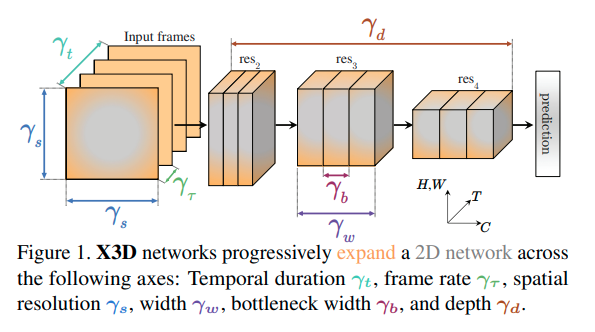

- `Note`: The structure of the is based on the figure above, it will be modified to tailor our project design's specific objectives

#### Network Building

In [20]:
from pytorchvideo.models.x3d import create_x3d

DROPOUT_RATE, WIDTH_FACTOR, DEPTH_FACTOR = 0.5, 2.1, 2.3


model = create_x3d(input_channel=3,
    input_clip_length=SEQUENCE_LENGTH,
    input_crop_size=SIZE,
    model_num_class=len(LABELS),
    dropout_rate=DROPOUT_RATE,
    width_factor=WIDTH_FACTOR,
    depth_factor=DEPTH_FACTOR,
    norm=torch.nn.BatchNorm3d,
    activation=torch.nn.ReLU)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


num_epochs = 300
patience = 20
early_stop_counter = 0
best_val_loss = float("inf")

# Loss function and optimizer with label smoothing and increased weight decay
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

#### Train the model

In [21]:
## Queue the montage because this model is about top traiiin
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
best_model_state = None  # Save the best model state

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch + 1}/{num_epochs}]")

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_dataloader), desc="Training", unit="batch") as pbar:
        for i, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            pbar.set_postfix(loss=f"{loss.item():.4f}")
            pbar.update(1)

    train_loss = running_loss / len(train_dataloader)
    train_acc = correct / total * 100
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with tqdm(total=len(val_dataloader), desc="Validation", unit="batch") as pbar:
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

                pbar.set_postfix(loss=f"{loss.item():.4f}")
                pbar.update(1)

    val_loss = val_running_loss / len(val_dataloader)
    val_acc = val_correct / val_total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)  # Adjust learning rate

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        early_stop_counter = 0
        best_model_state = model.state_dict()
        
    else:
        early_stop_counter += 1

    print(
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}, "
        f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}"
    )

    if early_stop_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch + 1}")
        break

if best_model_state:
    torch.save(best_model_state, "x3d_model.pth")
    print(f"\nBest model saved with Validation Accuracy: {best_val_acc:.2f}%")
    print(f"\nBest model saved with Validation Loss: {best_val_loss:.2f}%")

print("Training complete!")


Epoch [1/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.10s/batch, loss=1.5740]


Train Loss: 1.6113, Train Accuracy: 18.40, Val Loss: 1.6092, Val Accuracy: 20.00

Epoch [2/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.01s/batch, loss=1.5633]


Train Loss: 1.6017, Train Accuracy: 26.42, Val Loss: 1.6038, Val Accuracy: 25.83

Epoch [3/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.07s/batch, loss=1.5589]


Train Loss: 1.5932, Train Accuracy: 30.19, Val Loss: 1.5937, Val Accuracy: 23.33

Epoch [4/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.07s/batch, loss=1.4568]


Train Loss: 1.5810, Train Accuracy: 32.31, Val Loss: 1.5740, Val Accuracy: 29.17

Epoch [5/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.06s/batch, loss=1.2914]


Train Loss: 1.5554, Train Accuracy: 33.96, Val Loss: 1.5428, Val Accuracy: 33.33

Epoch [6/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.08s/batch, loss=1.2684]


Train Loss: 1.5309, Train Accuracy: 34.43, Val Loss: 1.5239, Val Accuracy: 35.00

Epoch [7/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.07s/batch, loss=1.1923]


Train Loss: 1.5038, Train Accuracy: 38.44, Val Loss: 1.5103, Val Accuracy: 36.67

Epoch [8/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.06s/batch, loss=1.2445]


Train Loss: 1.4985, Train Accuracy: 37.97, Val Loss: 1.4975, Val Accuracy: 37.50

Epoch [9/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.06s/batch, loss=1.2592]


Train Loss: 1.4843, Train Accuracy: 37.74, Val Loss: 1.4931, Val Accuracy: 38.33

Epoch [10/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.06s/batch, loss=1.1084]


Train Loss: 1.4673, Train Accuracy: 41.51, Val Loss: 1.4709, Val Accuracy: 40.00

Epoch [11/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.08s/batch, loss=1.0663]


Train Loss: 1.4607, Train Accuracy: 41.98, Val Loss: 1.4647, Val Accuracy: 38.33

Epoch [12/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.08s/batch, loss=1.0905]


Train Loss: 1.4411, Train Accuracy: 45.52, Val Loss: 1.4532, Val Accuracy: 40.83

Epoch [13/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.05s/batch, loss=1.1349]


Train Loss: 1.4220, Train Accuracy: 49.29, Val Loss: 1.4586, Val Accuracy: 42.50

Epoch [14/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.06s/batch, loss=1.0250]


Train Loss: 1.4092, Train Accuracy: 48.82, Val Loss: 1.4427, Val Accuracy: 44.17

Epoch [15/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.06s/batch, loss=1.0602]


Train Loss: 1.3996, Train Accuracy: 48.58, Val Loss: 1.4232, Val Accuracy: 46.67

Epoch [16/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.06s/batch, loss=1.0726]


Train Loss: 1.3731, Train Accuracy: 54.95, Val Loss: 1.4466, Val Accuracy: 40.83

Epoch [17/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.08s/batch, loss=1.0284]


Train Loss: 1.3636, Train Accuracy: 54.95, Val Loss: 1.4485, Val Accuracy: 45.00

Epoch [18/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.08s/batch, loss=1.0138]


Train Loss: 1.3637, Train Accuracy: 55.42, Val Loss: 1.4423, Val Accuracy: 42.50

Epoch [19/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.12s/batch, loss=1.0790]


Train Loss: 1.3359, Train Accuracy: 58.25, Val Loss: 1.4327, Val Accuracy: 45.00

Epoch [20/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.09s/batch, loss=1.0707]


Train Loss: 1.3031, Train Accuracy: 62.50, Val Loss: 1.4277, Val Accuracy: 45.00

Epoch [21/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.09s/batch, loss=1.0066]


Train Loss: 1.2829, Train Accuracy: 65.33, Val Loss: 1.4215, Val Accuracy: 48.33

Epoch [22/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.06s/batch, loss=1.0112]


Train Loss: 1.2713, Train Accuracy: 65.57, Val Loss: 1.4306, Val Accuracy: 44.17

Epoch [23/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.06s/batch, loss=1.0609]


Train Loss: 1.2551, Train Accuracy: 66.75, Val Loss: 1.4410, Val Accuracy: 44.17

Epoch [24/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.08s/batch, loss=1.0381]


Train Loss: 1.2672, Train Accuracy: 66.04, Val Loss: 1.4425, Val Accuracy: 40.00

Epoch [25/300]


Validation: 100%|██████████| 10/10 [00:12<00:00,  1.22s/batch, loss=1.1139]


Train Loss: 1.2130, Train Accuracy: 70.99, Val Loss: 1.4375, Val Accuracy: 44.17

Epoch [26/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.12s/batch, loss=1.0726]


Train Loss: 1.2118, Train Accuracy: 72.88, Val Loss: 1.4185, Val Accuracy: 49.17

Epoch [27/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.12s/batch, loss=1.1534]


Train Loss: 1.1879, Train Accuracy: 73.35, Val Loss: 1.4155, Val Accuracy: 45.83

Epoch [28/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.14s/batch, loss=1.0744]


Train Loss: 1.1616, Train Accuracy: 79.48, Val Loss: 1.4237, Val Accuracy: 45.83

Epoch [29/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.15s/batch, loss=1.2141]


Train Loss: 1.1570, Train Accuracy: 78.07, Val Loss: 1.4601, Val Accuracy: 40.83

Epoch [30/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.14s/batch, loss=1.0759]


Train Loss: 1.1181, Train Accuracy: 80.42, Val Loss: 1.3971, Val Accuracy: 50.83

Epoch [31/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.10s/batch, loss=1.0772]


Train Loss: 1.1412, Train Accuracy: 79.25, Val Loss: 1.4130, Val Accuracy: 45.83

Epoch [32/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.11s/batch, loss=1.0947]


Train Loss: 1.0882, Train Accuracy: 83.49, Val Loss: 1.4062, Val Accuracy: 46.67

Epoch [33/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.09s/batch, loss=1.0574]


Train Loss: 1.0799, Train Accuracy: 84.20, Val Loss: 1.3879, Val Accuracy: 48.33

Epoch [34/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.12s/batch, loss=1.0579]


Train Loss: 1.0869, Train Accuracy: 82.78, Val Loss: 1.3950, Val Accuracy: 48.33

Epoch [35/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.10s/batch, loss=1.1100]


Train Loss: 1.0720, Train Accuracy: 84.67, Val Loss: 1.3793, Val Accuracy: 50.83

Epoch [36/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.12s/batch, loss=1.0900]


Train Loss: 1.0664, Train Accuracy: 85.38, Val Loss: 1.4135, Val Accuracy: 46.67

Epoch [37/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.07s/batch, loss=1.1151]


Train Loss: 1.0587, Train Accuracy: 88.21, Val Loss: 1.4153, Val Accuracy: 45.83

Epoch [38/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.06s/batch, loss=1.1572]


Train Loss: 1.0820, Train Accuracy: 84.67, Val Loss: 1.4383, Val Accuracy: 44.17

Epoch [39/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.07s/batch, loss=1.1410]


Train Loss: 1.0547, Train Accuracy: 86.79, Val Loss: 1.4075, Val Accuracy: 48.33

Epoch [40/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.07s/batch, loss=1.1394]


Train Loss: 1.0306, Train Accuracy: 88.68, Val Loss: 1.4308, Val Accuracy: 45.83

Epoch [41/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.11s/batch, loss=1.0663]


Train Loss: 1.0168, Train Accuracy: 90.57, Val Loss: 1.3944, Val Accuracy: 50.83

Epoch [42/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.19s/batch, loss=0.9933]


Train Loss: 1.0048, Train Accuracy: 91.27, Val Loss: 1.4051, Val Accuracy: 48.33

Epoch [43/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.10s/batch, loss=1.0572]


Train Loss: 0.9912, Train Accuracy: 92.69, Val Loss: 1.3817, Val Accuracy: 49.17

Epoch [44/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.08s/batch, loss=1.1157]


Train Loss: 1.0018, Train Accuracy: 91.98, Val Loss: 1.3970, Val Accuracy: 50.00

Epoch [45/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.12s/batch, loss=1.0947]


Train Loss: 0.9655, Train Accuracy: 95.99, Val Loss: 1.3721, Val Accuracy: 50.83

Epoch [46/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.13s/batch, loss=1.0448]


Train Loss: 0.9722, Train Accuracy: 95.05, Val Loss: 1.4086, Val Accuracy: 45.83

Epoch [47/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.08s/batch, loss=1.0724]


Train Loss: 0.9931, Train Accuracy: 92.22, Val Loss: 1.4085, Val Accuracy: 45.83

Epoch [48/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.05s/batch, loss=1.0226]


Train Loss: 0.9819, Train Accuracy: 94.10, Val Loss: 1.3725, Val Accuracy: 53.33

Epoch [49/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.03s/batch, loss=1.0177]


Train Loss: 0.9630, Train Accuracy: 95.05, Val Loss: 1.3821, Val Accuracy: 50.83

Epoch [50/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.04s/batch, loss=1.0041]


Train Loss: 0.9775, Train Accuracy: 93.87, Val Loss: 1.3905, Val Accuracy: 48.33

Epoch [51/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.05s/batch, loss=1.1390]


Train Loss: 0.9701, Train Accuracy: 94.58, Val Loss: 1.3938, Val Accuracy: 50.00

Epoch [52/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.07s/batch, loss=1.0718]


Train Loss: 0.9773, Train Accuracy: 93.63, Val Loss: 1.3722, Val Accuracy: 49.17

Epoch [53/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.03s/batch, loss=1.1028]


Train Loss: 0.9604, Train Accuracy: 96.23, Val Loss: 1.3733, Val Accuracy: 50.00

Epoch [54/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.02s/batch, loss=1.0961]


Train Loss: 0.9421, Train Accuracy: 97.17, Val Loss: 1.3730, Val Accuracy: 50.83

Epoch [55/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.03s/batch, loss=1.0847]


Train Loss: 0.9390, Train Accuracy: 97.64, Val Loss: 1.3588, Val Accuracy: 55.00

Epoch [56/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.02s/batch, loss=1.0936]


Train Loss: 0.9500, Train Accuracy: 96.70, Val Loss: 1.3535, Val Accuracy: 54.17

Epoch [57/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.04s/batch, loss=1.0868]


Train Loss: 0.9410, Train Accuracy: 97.41, Val Loss: 1.3681, Val Accuracy: 50.00

Epoch [58/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.02s/batch, loss=1.0170]


Train Loss: 0.9336, Train Accuracy: 97.88, Val Loss: 1.3749, Val Accuracy: 50.00

Epoch [59/300]


Validation: 100%|██████████| 10/10 [00:11<00:00,  1.11s/batch, loss=1.0683]


Train Loss: 0.9365, Train Accuracy: 97.88, Val Loss: 1.3781, Val Accuracy: 50.83

Epoch [60/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.04s/batch, loss=1.0845]


Train Loss: 0.9479, Train Accuracy: 96.46, Val Loss: 1.3703, Val Accuracy: 50.83

Epoch [61/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.05s/batch, loss=1.0644]


Train Loss: 0.9599, Train Accuracy: 96.23, Val Loss: 1.3771, Val Accuracy: 50.00

Epoch [62/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.05s/batch, loss=1.1109]


Train Loss: 0.9373, Train Accuracy: 98.11, Val Loss: 1.3912, Val Accuracy: 50.83

Epoch [63/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.04s/batch, loss=1.0793]


Train Loss: 0.9455, Train Accuracy: 97.17, Val Loss: 1.3655, Val Accuracy: 52.50

Epoch [64/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.04s/batch, loss=1.0539]


Train Loss: 0.9474, Train Accuracy: 96.93, Val Loss: 1.3647, Val Accuracy: 52.50

Epoch [65/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.03s/batch, loss=1.0800]


Train Loss: 0.9309, Train Accuracy: 98.11, Val Loss: 1.3817, Val Accuracy: 50.00

Epoch [66/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.04s/batch, loss=1.0686]


Train Loss: 0.9425, Train Accuracy: 97.64, Val Loss: 1.3650, Val Accuracy: 52.50

Epoch [67/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.04s/batch, loss=1.0723]


Train Loss: 0.9472, Train Accuracy: 96.46, Val Loss: 1.3730, Val Accuracy: 50.83

Epoch [68/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.08s/batch, loss=1.0763]


Train Loss: 0.9394, Train Accuracy: 97.88, Val Loss: 1.3674, Val Accuracy: 53.33

Epoch [69/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.04s/batch, loss=1.0390]


Train Loss: 0.9282, Train Accuracy: 98.11, Val Loss: 1.3606, Val Accuracy: 53.33

Epoch [70/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.05s/batch, loss=1.0693]


Train Loss: 0.9355, Train Accuracy: 97.88, Val Loss: 1.3701, Val Accuracy: 51.67

Epoch [71/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.03s/batch, loss=1.0813]


Train Loss: 0.9384, Train Accuracy: 97.17, Val Loss: 1.3692, Val Accuracy: 51.67

Epoch [72/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.04s/batch, loss=1.0748]


Train Loss: 0.9369, Train Accuracy: 97.17, Val Loss: 1.3718, Val Accuracy: 53.33

Epoch [73/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.05s/batch, loss=1.0715]


Train Loss: 0.9379, Train Accuracy: 97.17, Val Loss: 1.3717, Val Accuracy: 51.67

Epoch [74/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.07s/batch, loss=1.0641]


Train Loss: 0.9433, Train Accuracy: 97.88, Val Loss: 1.3672, Val Accuracy: 50.83

Epoch [75/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.07s/batch, loss=1.0671]


Train Loss: 0.9288, Train Accuracy: 98.35, Val Loss: 1.3700, Val Accuracy: 50.83

Epoch [76/300]


Validation: 100%|██████████| 10/10 [00:10<00:00,  1.07s/batch, loss=1.0686]

Train Loss: 0.9290, Train Accuracy: 98.35, Val Loss: 1.3716, Val Accuracy: 49.17

Early stopping at epoch 76

Best model saved with Validation Accuracy: 54.17%

Best model saved with Validation Loss: 1.35%
Training complete!


- `Remarks`: Why use more than 50 epochs you ask? Because some [Indian guy on YouTube](https://youtu.be/QmtSkq3DYko?si=V28jCOfot8MeHep6) used 500 epochs to train his Action Recognition model, therefore it is also wise to use the same training scheme. What a chad! (Edit: No need naman pala, sadge)

#### Plot the model and get the metrics

In [1]:
plot_history(train_losses, val_losses, train_accuracies, val_accuracies)

NameError: name 'plot_history' is not defined

In [23]:
test_dataset = VideoDataset(
    root_dir=dataset_paths['test'],
    frame_height=SIZE,
    frame_width=SIZE,
    sequence_length=SEQUENCE_LENGTH,
)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

Total videos found: 65
Class to index mapping: {'BarbellCurl': 0, 'Deadlift': 1, 'LateralRaises': 2, 'OverheadPress': 3, 'Squat': 4}
Video paths (first 5): ['PD_Dataset\\test\\BarbellCurl\\barbell_curls (20).avi', 'PD_Dataset\\test\\BarbellCurl\\barbell_curls (25).avi', 'PD_Dataset\\test\\BarbellCurl\\barbell_curls (44).avi', 'PD_Dataset\\test\\BarbellCurl\\barbell_curls (57).avi', 'PD_Dataset\\test\\BarbellCurl\\barbell_curls (67).avi']


In [24]:
# Evaluate the model on the validation dataset
test_metrics = evaluate_model(model, test_dataloader, criterion, device)

# Print metrics
print(f"Validation Loss: {test_metrics['loss']:.4f}")
print(f"Validation Accuracy: {test_metrics['accuracy']:.2f}%")

Validation Loss: 1.3002
Validation Accuracy: 61.54%


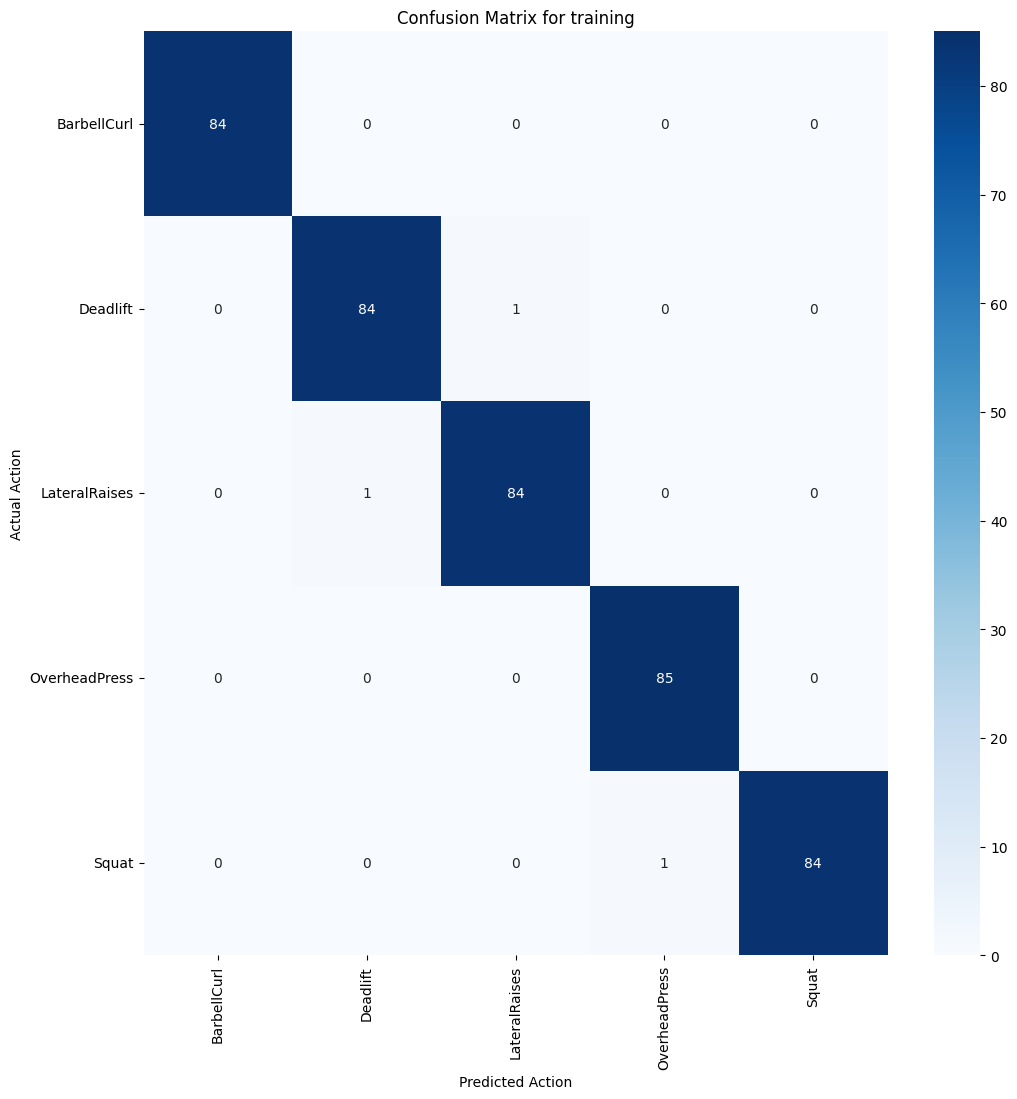

In [25]:
actual, predicted = get_actual_predicted_labels(train_dataloader, model)
plot_confusion_matrix(actual, predicted, LABELS, 'training')

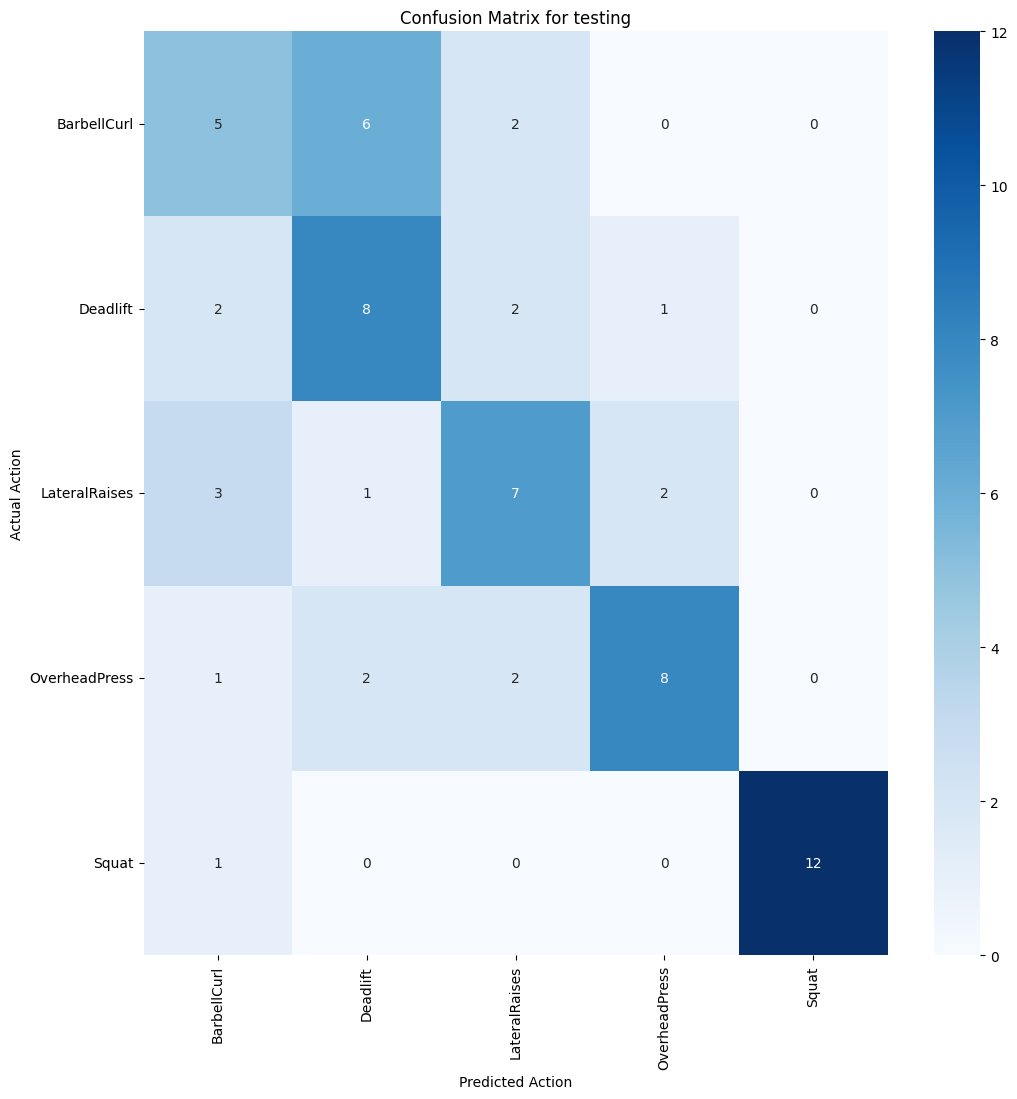

In [26]:
actual, predicted = get_actual_predicted_labels(test_dataloader, model)
plot_confusion_matrix(actual, predicted, LABELS, 'testing')

In [27]:
precision, recall, f1_scores = calculate_classification_metrics(actual, predicted, LABELS) # Test results

In [ ]:
precision

In [ ]:
recall

In [ ]:
f1_scores

In [ ]:
print("Average F1 Score:", np.mean([val for key, val in f1_scores.items()])) # Average F1 Score

## Load Model and Test

#### Test the Model

In [ ]:
## Load the trained model
from ModelArchives.pytorchvideo.models.x3d import create_x3d

load_model = create_x3d(input_channel=3,
                   input_clip_length=SEQUENCE_LENGTH,
                   input_crop_size=SIZE,
                   model_num_class=len(LABELS),
                   dropout_rate=DROPOUT_RATE,
                   width_factor=WIDTH_FACTOR,
                   depth_factor=DEPTH_FACTOR,
                   norm=torch.nn.BatchNorm3d,
                   activation=torch.nn.ReLU)
load_model.load_state_dict(torch.load("x3d_model.pth"))

device = "cuda" if torch.cuda.is_available() else "cpu"

load_model = load_model.to(device).eval()

In [ ]:
from moviepy import VideoFileClip

# Preprocessing function for video frames
def preprocess_frames(frames, size, device):
    # Convert frames to numpy array, normalize, and create a tensor
    frames_array = np.array(frames, dtype=np.float32) / 255.0  # Normalize to [0, 1]
    frames_tensor = (
        torch.from_numpy(frames_array)
        .permute(3, 0, 1, 2)  # Convert to (C, T, H, W)
        .unsqueeze(0)  # Add batch dimension
        .to(device)
    )
    return frames_tensor

# Function to process a video and make predictions
def process_video(video_path, sequence_length, size, device):
    clip = VideoFileClip(video_path)
    frames = []
    predictions = []

    for frame in clip.iter_frames(fps=SEQUENCE_LENGTH):  # Extract frames at 10 FPS
        # Resize and normalize frame
        resized_frame = Image.fromarray(frame).resize((size, size))
        rgb_frame = np.asarray(resized_frame)
        frames.append(rgb_frame)

        # When enough frames are collected, run inference
        if len(frames) == sequence_length:
            frames_tensor = preprocess_frames(frames, size, device)
            with torch.no_grad():
                prediction = load_model(frames_tensor)
            predicted_index = torch.argmax(prediction, dim=1).item()
            predicted_label = LABELS[predicted_index]
            predictions.append(predicted_label)

            print(f"Predicted Activity: {predicted_label}")
            frames = []  # Clear frames for the next sequence

    return predictions

In [ ]:
# Specify the video path
video_path = "./test_case/Deadlift1.mp4"

# Process the video and get predictions
predictions = process_video(video_path, SEQUENCE_LENGTH, SIZE, device)

# Display predictions in the notebook
from IPython.display import display, HTML

html_predictions = "<h3>Predicted Activities:</h3><ul>"
for i, pred in enumerate(predictions, start=1):
    html_predictions += f"<li>Sequence {i}: {pred}</li>"
html_predictions += "</ul>"
display(HTML(html_predictions))